Міністерство освіти і науки України 

Національний технічний університет України «КПІ ім. Ігоря Сікорського»

Факультет інформатики та обчислювальної техніки

Кафедра інформатики та програмної інженерії

Аналіз даних в інформаційно-управляючих системах

Виконанав студент:

ІП-01 Хернуф Валід Алі-Еддін

Київ 2022


---

# **Звіт до лабораторної роботи №6**

## **Основне завдання**

Спочатку імпортуємо усі потрібні бібліотеки для праці: matplotlib.pyplot, pandas, numpy та деякі методи з бібліотеки sklearn.

In [218]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import pandas as p
import numpy as n

Завантажуємо дані з файлу titanic.csv:

In [219]:
def read_dataset(path, separ, dec, en):
    return p.read_csv(path, sep = separ, decimal = dec, encoding = en)

dFrame = read_dataset("titanic.csv", ",", ".", "cp1252")

Досліджуємо дані:

In [220]:
dFrame.info()
dFrame.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Виправляємо тип даних стовпця, та видаляємо непотрібні стовпці:

In [221]:
def set_columns_type_str(dFrame, columns):
    for column in columns:
        dFrame[column] = dFrame[column].astype(str)

def drop_columns(dFrame, columns):
    for column in columns:
        dFrame = dFrame.drop(column, axis = 1)
    return dFrame

set_columns_type_str(dFrame, ["Pclass"])
dFrame = drop_columns(dFrame, ["PassengerId", "Name", "Ticket"])
dFrame.info()
dFrame.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 48.8+ KB


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


Перевірка даних на пропуски:

In [222]:
def check_emptyness(dFrame):
    print("Columns with empty values (percentage):")
    percents = []
    for column in dFrame.columns:
        percents.append((round(dFrame[column].isnull().sum() / len(dFrame[column])* 100, 2), dFrame.columns.get_loc(column)))
    percents.sort(key = lambda tup: tup[0], reverse = True)
    nothing = True
    for percent in percents:
        if (percent[0] > 0):
            print(f"{dFrame.columns[percent[1]]}: {percent[0]}%")
            nothing = False
    if (nothing): print("There is any empty values!")

check_emptyness(dFrame)

Columns with empty values (percentage):
Cabin: 77.1%
Age: 19.87%
Embarked: 0.22%


Стовпчик про кабіни видалимо, через велику кількість пропусків. інші стовпчики заповнимо модою:

In [223]:
def fill_mode(dFrame, columns):
    for column in columns:
        dFrame[column] = dFrame[column].fillna(dFrame[column].mode()[0])
    return dFrame

dFrame = drop_columns(dFrame, ["Cabin"])
dFrame = fill_mode(dFrame, ["Age", "Embarked"])

Перевірка даних на пропуски після виправлення:

In [224]:
check_emptyness(dFrame)

Columns with empty values (percentage):
There is any empty values!


Перетворка категоріальних змінних в індикаторні змінні:

In [225]:
dFrame = p.get_dummies(dFrame)

Поділ даних на тестові та тренувальні:

In [226]:
def split_data(x, y):
    return train_test_split(x, y, test_size=0.3)

x_train, x_test, y_train, y_test = split_data(dFrame.drop(columns = "Survived"), dFrame["Survived"])

### 1. Побудува моделей, в яких можна визначити, чи виживе пасажир:

In [227]:
def build_tree_method(type, x_train, y_train, depth):
    tree = type(max_depth = depth)
    tree.fit(x_train, y_train)
    return tree

def build_boosting_method(type, x_train, y_train, l_rate):
    boost = type(learning_rate = l_rate)
    boost.fit(x_train, y_train)
    return boost

def get_scores(method, x_train, y_train, x_test, y_test):
    cv_score = cross_val_score(method, x_train, y_train, cv = 5)
    score = method.score(x_test, y_test)
    return cv_score, score

def print_res(method, cvs, s):
    print(f"{method} method:")
    print("Cross validation score: ", cvs.mean())
    print("Score: ", s)

methods = ["Decision tree", "Random forest", "Extra trees", "Ada boost", "Gradient boosting"]

Побудова моделі "Decision tree":

In [228]:
dt = build_tree_method(DecisionTreeClassifier, x_train, y_train, 5)
dt_cvs, dt_s = get_scores(dt, x_train, y_train, x_test, y_test)
print_res(methods[0], dt_cvs, dt_s)

Decision tree method:
Cross validation score:  0.773509677419355
Score:  0.7873134328358209


Побудова моделі "Random forest":

In [229]:
rf = build_tree_method(RandomForestClassifier, x_train, y_train, 5)
rf_cvs, rf_s = get_scores(rf, x_train, y_train, x_test, y_test)
print_res(methods[1], rf_cvs, rf_s)

Random forest method:
Cross validation score:  0.7895483870967742
Score:  0.8395522388059702


Побудова моделі "Extra trees":

In [230]:
et = build_tree_method(ExtraTreesClassifier, x_train, y_train, 5)
et_cvs, et_s = get_scores(et, x_train, y_train, x_test, y_test)
print_res(methods[2], et_cvs, et_s)

Extra trees method:
Cross validation score:  0.7895999999999999
Score:  0.8395522388059702


Побудова моделі "Ada boost":

In [231]:
ab = build_boosting_method(AdaBoostClassifier, x_train, y_train, 0.5)
ab_cvs, ab_s = get_scores(ab, x_train, y_train, x_test, y_test)
print_res(methods[3], ab_cvs, ab_s)

Ada boost method:
Cross validation score:  0.7975999999999999
Score:  0.832089552238806


Побудова моделі "Gradient boostring":

In [232]:
gb = build_boosting_method(GradientBoostingClassifier, x_train, y_train, 0.5)
gb_cvs, gb_s = get_scores(gb, x_train, y_train, x_test, y_test)
print_res(methods[4], ab_cvs, ab_s)

Gradient boosting method:
Cross validation score:  0.7975999999999999
Score:  0.832089552238806


### 2. Порівняння результатів та знаходження найкращої моделі:

In [233]:
def print_best_method(methods, scores):
    min_i = n.argmax(scores)
    print("Best model is:")
    print(f"{methods[min_i]} method with {scores[min_i]} score")

print_best_method(methods, [dt_s, rf_s, et_s, ab_s, gb_s])

Best model is:
Random forest method with 0.8395522388059702 score


## **Додаткове завдання**

Імпортуємо всі потрібні для додаткового завдання бібліотекі: kneed, plotly.express, matplotlib та метод з бібліотеки sklearn:

In [234]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as pyp
from kneed import KneeLocator
import plotly.express as px

Завантажуємо дані з файлу "Data2.csv":

In [235]:
dFrame = read_dataset("Data2.csv", ";", ",", "windows-1252")

Виводимо інформацію про набір даних:

In [236]:
dFrame.info()
dFrame.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Region          217 non-null    object 
 2   GDP per capita  190 non-null    float64
 3   Populatiion     216 non-null    float64
 4   CO2 emission    205 non-null    float64
 5   Area            217 non-null    float64
dtypes: float64(4), object(2)
memory usage: 8.5+ KB


,Country Name,Region,GDP per capita,Populatiion,CO2 emission,Area
0,Afghanistan,South Asia,561.778746,34656032.0,9809.225,652860.0
1,Albania,Europe & Central Asia,4124.982390,2876101.0,5716.853,28750.0
2,Algeria,Middle East & North Africa,3916.881571,40606052.0,145400.217,2381740.0
3,American Samoa,East Asia & Pacific,11834.745230,55599.0,NaN,200.0
4,Andorra,Europe & Central Asia,36988.622030,77281.0,462.042,470.0


Виправляємо всі помилки в наборі даних, а саме: Зміна назви стовпчика, прибирання негативних значень та заповненя пропусків середніми значенням.

In [237]:
def remove_errors(dFrame):
    dFrame.rename(columns={'Populatiion' : 'Population'}, inplace = True)
    index = dFrame.index
    dFrame.iloc[index[dFrame['Country Name'] == 'Eritrea'], \
                dFrame.columns.get_loc('Population')] = 3662244
    remove_negatives(dFrame, 'GDP per capita')
    remove_negatives(dFrame, 'Area')
    fill_empty_fields(dFrame, 'GDP per capita')
    fill_empty_fields(dFrame, 'CO2 emission')

def remove_negatives(dFrame, column):
    dFrame[column] = dFrame[column].abs()

def fill_empty_fields(dFrame, column):
    dFrame[column].fillna(dFrame[column].mean(), inplace = True)

remove_errors(dFrame)
dFrame.info()
dFrame.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Region          217 non-null    object 
 2   GDP per capita  217 non-null    float64
 3   Population      217 non-null    float64
 4   CO2 emission    217 non-null    float64
 5   Area            217 non-null    float64
dtypes: float64(4), object(2)
memory usage: 8.5+ KB


,Country Name,Region,GDP per capita,Population,CO2 emission,Area
0,Afghanistan,South Asia,561.778746,34656032.0,9809.225000,652860.0
1,Albania,Europe & Central Asia,4124.982390,2876101.0,5716.853000,28750.0
2,Algeria,Middle East & North Africa,3916.881571,40606052.0,145400.217000,2381740.0
3,American Samoa,East Asia & Pacific,11834.745230,55599.0,165114.116337,200.0
4,Andorra,Europe & Central Asia,36988.622030,77281.0,462.042000,470.0


Додаємо стовпчик з щільністю населення:

In [238]:
def add_column(dFrame, column, condition):
    dFrame[column] = condition

add_column(dFrame, "Population density", dFrame["Population"] / dFrame["Area"])
dFrame.info()
dFrame.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Name        217 non-null    object 
 1   Region              217 non-null    object 
 2   GDP per capita      217 non-null    float64
 3   Population          217 non-null    float64
 4   CO2 emission        217 non-null    float64
 5   Area                217 non-null    float64
 6   Population density  217 non-null    float64
dtypes: float64(5), object(2)
memory usage: 10.2+ KB


,Country Name,Region,GDP per capita,Population,CO2 emission,Area,Population density
0,Afghanistan,South Asia,561.778746,34656032.0,9809.225000,652860.0,53.083405
1,Albania,Europe & Central Asia,4124.982390,2876101.0,5716.853000,28750.0,100.038296
2,Algeria,Middle East & North Africa,3916.881571,40606052.0,145400.217000,2381740.0,17.048902
3,American Samoa,East Asia & Pacific,11834.745230,55599.0,165114.116337,200.0,277.995000
4,Andorra,Europe & Central Asia,36988.622030,77281.0,462.042000,470.0,164.427660


### 1. Побудова кластерної моделі:


Знаходимо суму квадратів похибок:

In [239]:
def get_se_sum(f, arguments):
    se_sum = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **arguments)
        kmeans.fit(f)
        se_sum.append(kmeans.inertia_)
    return se_sum

f = dFrame[['GDP per capita','Population density']]
arguments = {'init': 'random', 'n_init': 10, 'max_iter': 300,}
se_sum = get_se_sum(f, arguments)

Візуалізуємо залежність суми квадратів похибок від кількості кластерів:

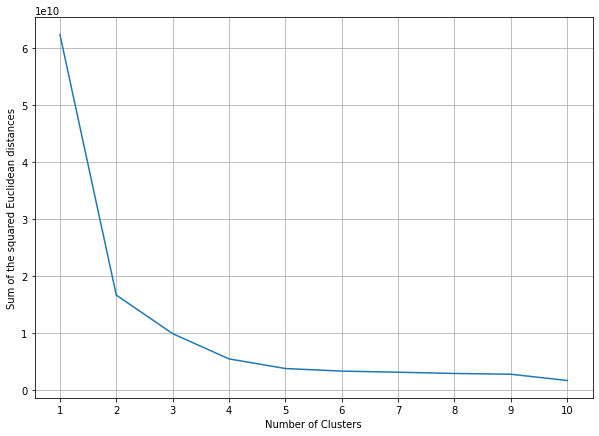

In [240]:
def elbow_plot(se_sum):
    pyp.figure(figsize=(10, 7))
    pyp.plot(range(1, 11), se_sum)
    pyp.xticks(range(1, 11))
    pyp.ylabel('Sum of the squared Euclidean distances')
    pyp.xlabel('Number of Clusters')
    pyp.grid(linestyle='-')
    pyp.show()

elbow_plot(se_sum)

За допомогою методу локтя визначаємо оптимальну кілкість кластерів:

In [241]:
def knee_point(se_sum):
    knee = KneeLocator(range(1, 11), se_sum, curve="convex", direction="decreasing")
    return knee.elbow

print(f"Elbow point: {knee_point(se_sum)}")

Elbow point: 3


Візуалізуємо кластери:

In [242]:
def cluster_plot(dFrame, x_c, y_c, hv_d, f):
    km = KMeans(init = 'random', n_clusters = 3)
    km.fit(f)
    fig = px.scatter(dFrame, 
                     x = x_c,
                     y = y_c,
                     color = km.labels_,
                     hover_data = hv_d)
    fig.update(layout_coloraxis_showscale=False)
    fig.show()

cluster_plot(dFrame, "GDP per capita", "Population density", ["Country Name","Region"], f)

### 2. Виведення частотних гістограм всіх показників файла Data2.csv, використовуючи цикл:

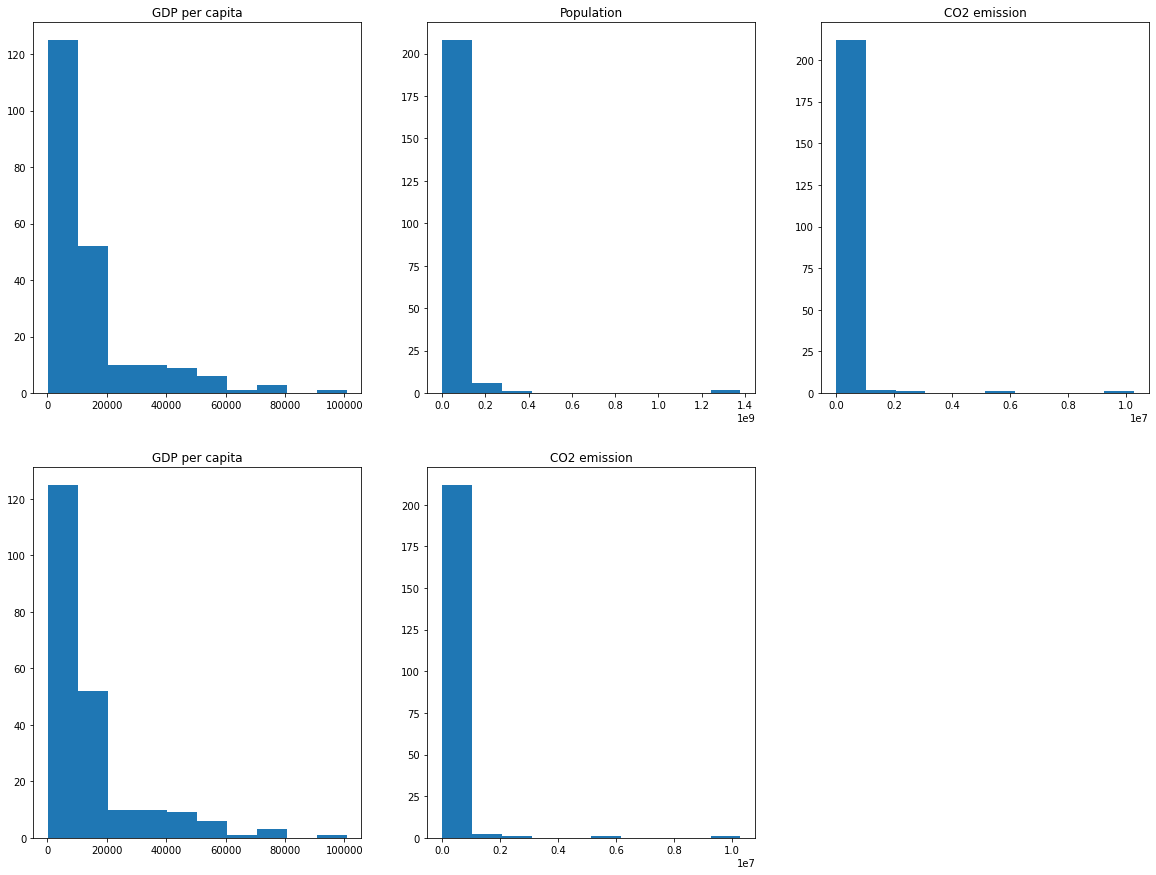

In [243]:
def plot_bars(dFrame, columns):
    fig, axes = pyp.subplots(2, 3, figsize=(20,15))
    for i in range(2):
        for j in range(3):
            axes[i][j].set_title(columns[(i*j) + j])
            axes[i][j].hist(dFrame[columns[(i*j) + j]])
    fig.delaxes(axes[1][2])
    pyp.show()

plot_bars(dFrame, dFrame.columns[2:])

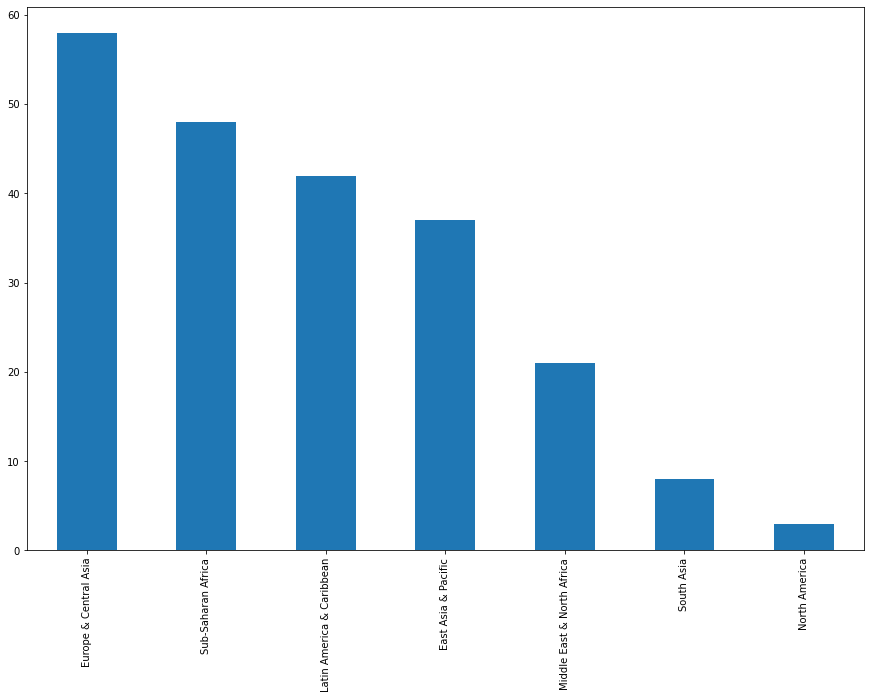

In [244]:
def bar_columns(dFrame, column):
    dFrame[column].value_counts().plot(kind = "bar", figsize = (15, 10))
    pyp.show()

bar_columns(dFrame, "Region")

### 3. Cтворення функції, яка на вхід отримує два набори даних, перевіряє чи є лінійна залежність:


In [245]:
def LinearDependence(first, second):
    return abs(n.corrcoef(first, second)[0,1]) > 0.8

x = n.random.randint(0, 100, 100)
y =  5 * x + n.random.normal(0, 10, 100)
y2 = n.random.normal(0, 10, 100)
print(LinearDependence(x, y))
print(LinearDependence(x, y2))

True
False
